In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import h5py
from PIL import Image
import os
import datetime as dt
import re
from skimage import exposure
%matplotlib inline 


In [6]:
def split(str, num):
    return [ str[start:start+num] for start in range(0, len(str), num) ]

<ipython-input-39-79ab2220ad95>:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  fileMetadata = f['HDFEOS INFORMATION']['StructMetadata.0'].value.split() # Read file metadata
<ipython-input-39-79ab2220ad95>:16: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  red = lum.value * scaleFactor
<ipython-input-39-79ab2220ad95>:17: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  green = lum.value * scaleFactor
<ipython-input-39-79ab2220ad95>:18: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  blue = lum.value * scaleFactor
<ipython-input-39-79ab2220ad95>:19: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  nir = lum.value * scaleFactor
<ipython-input-39-79ab2220ad95>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retai

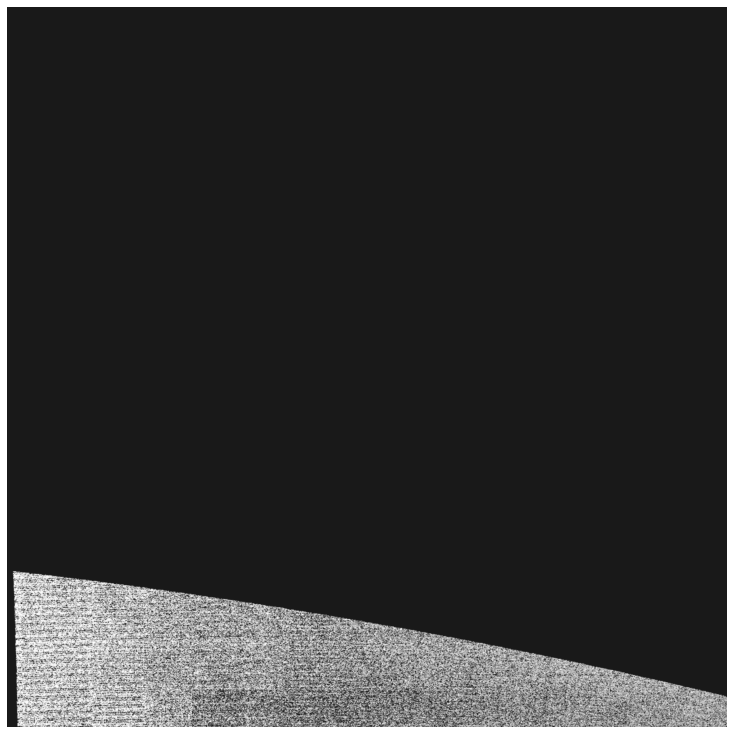

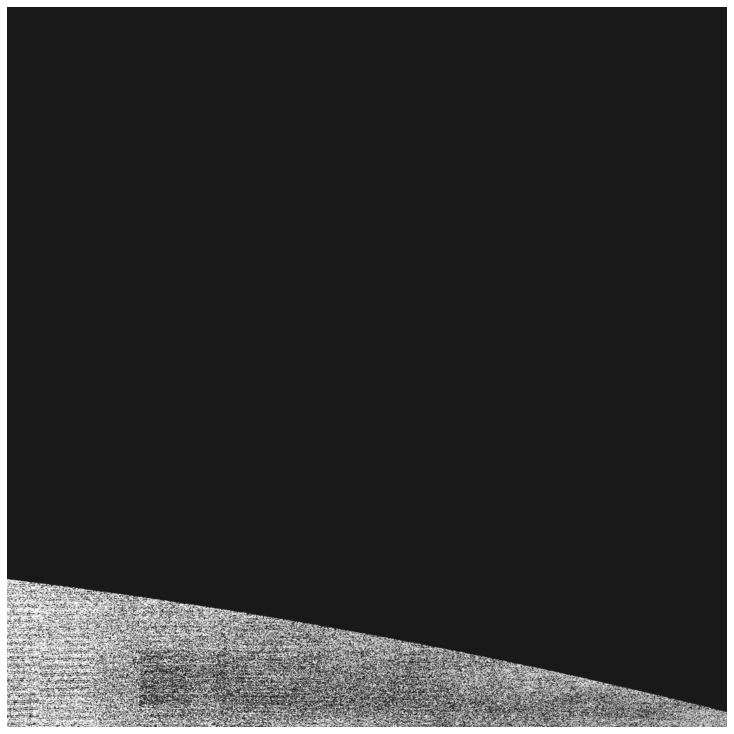

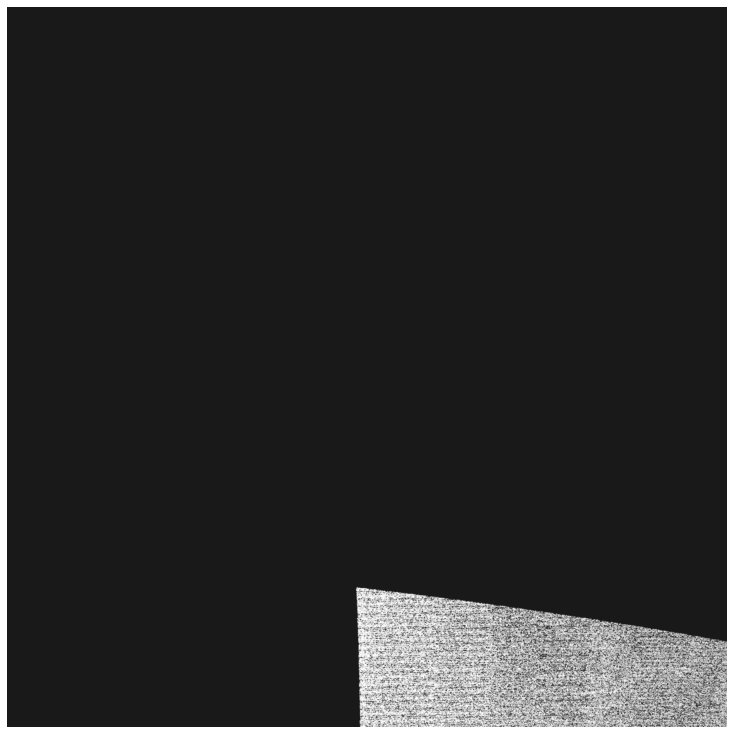

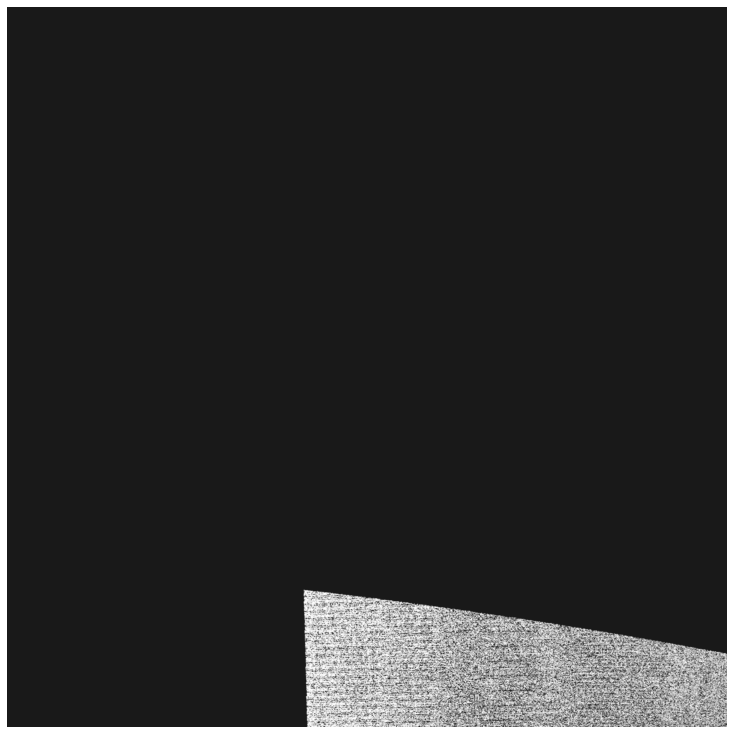

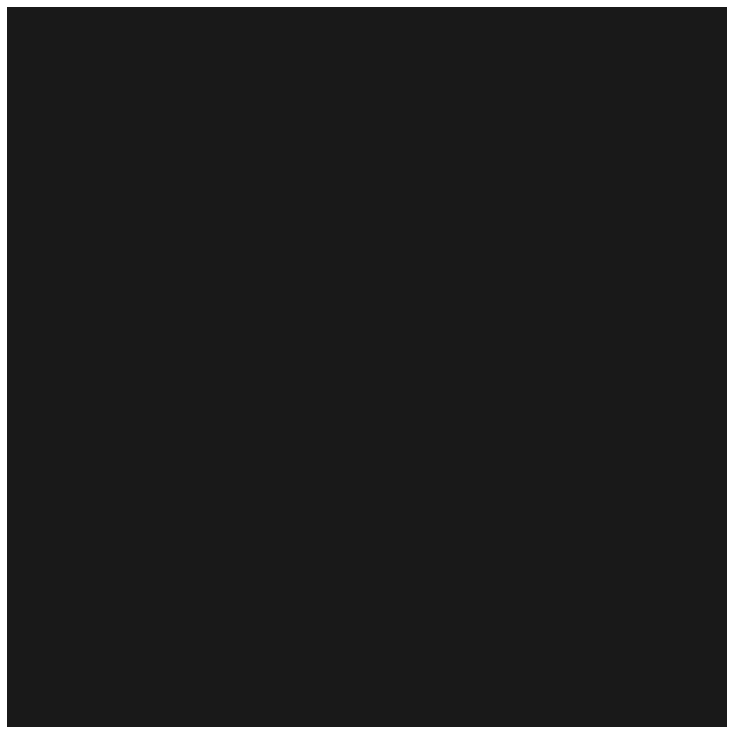

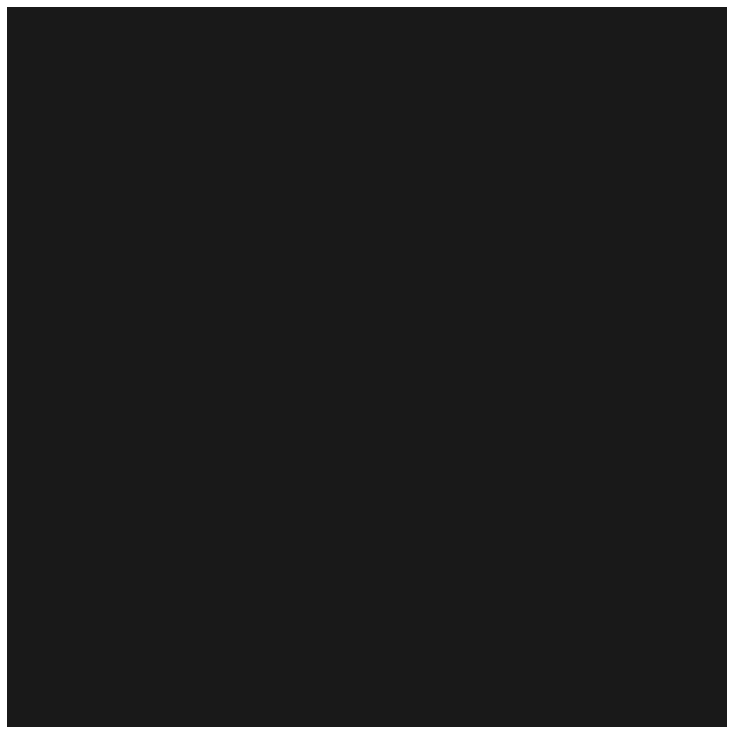

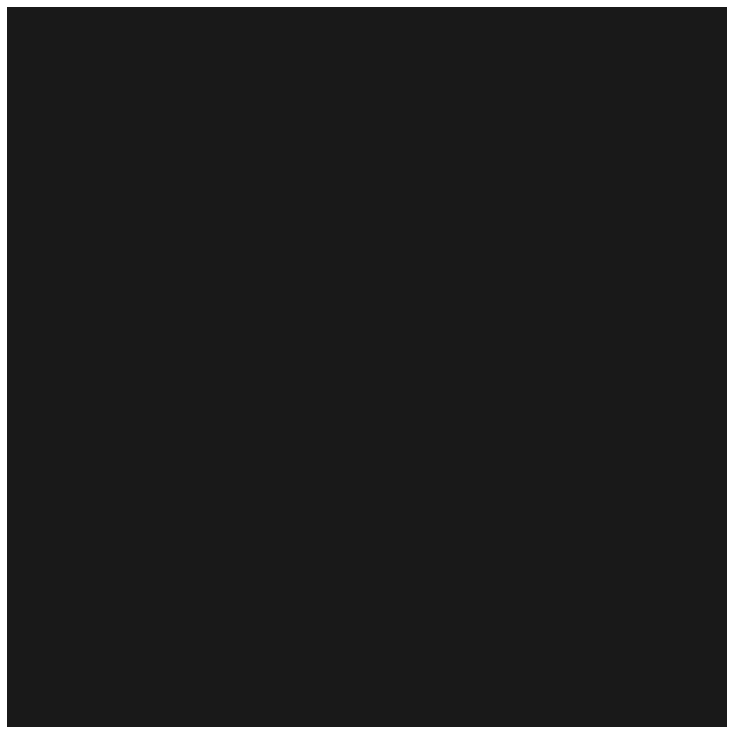

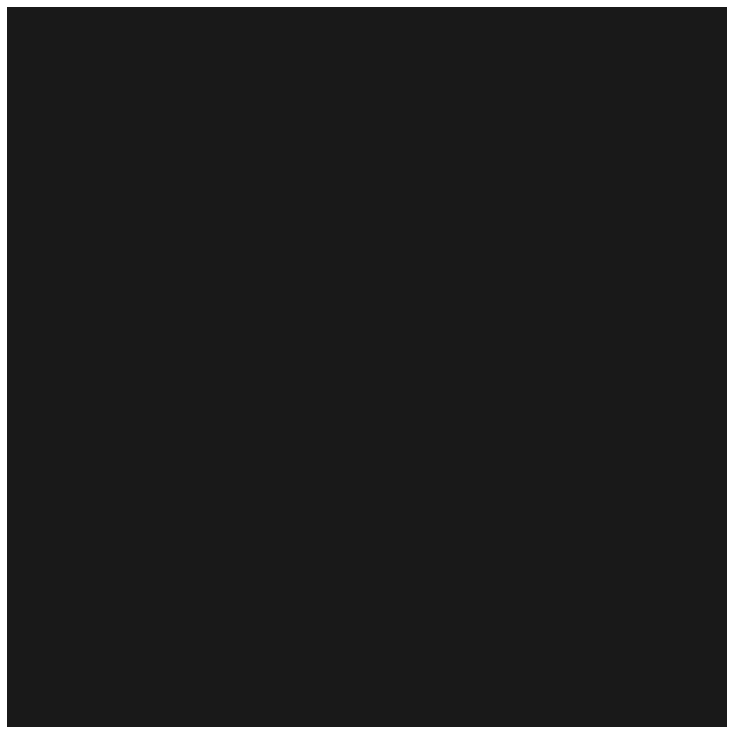

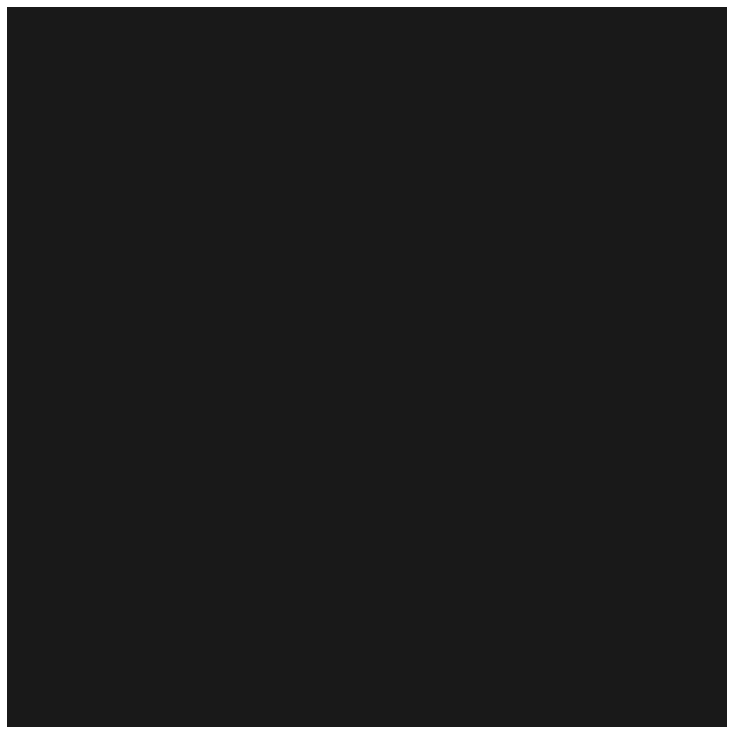

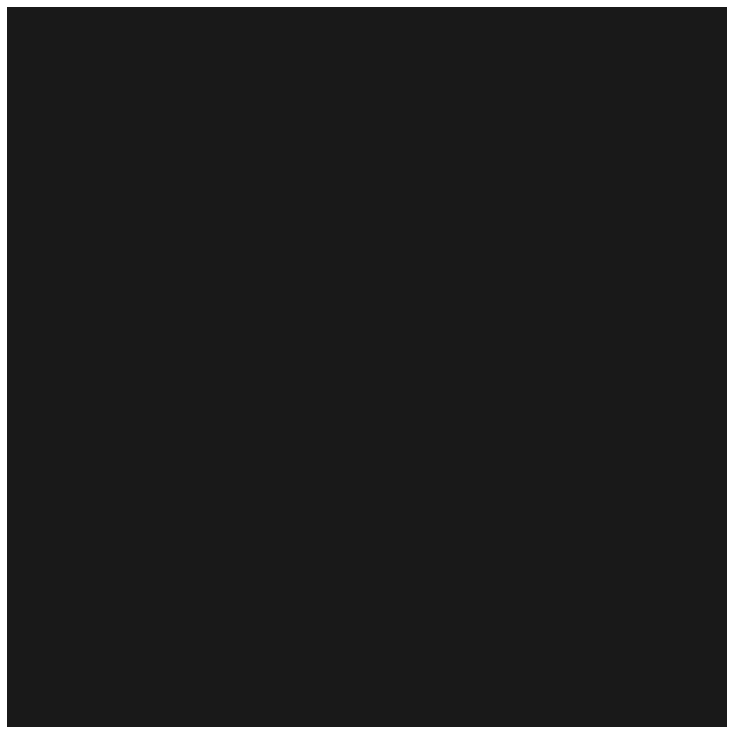

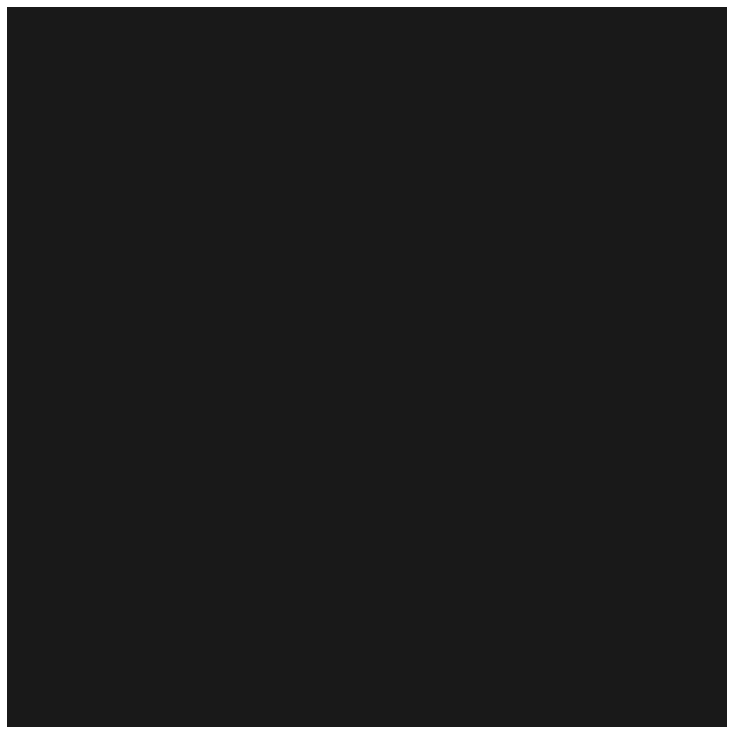

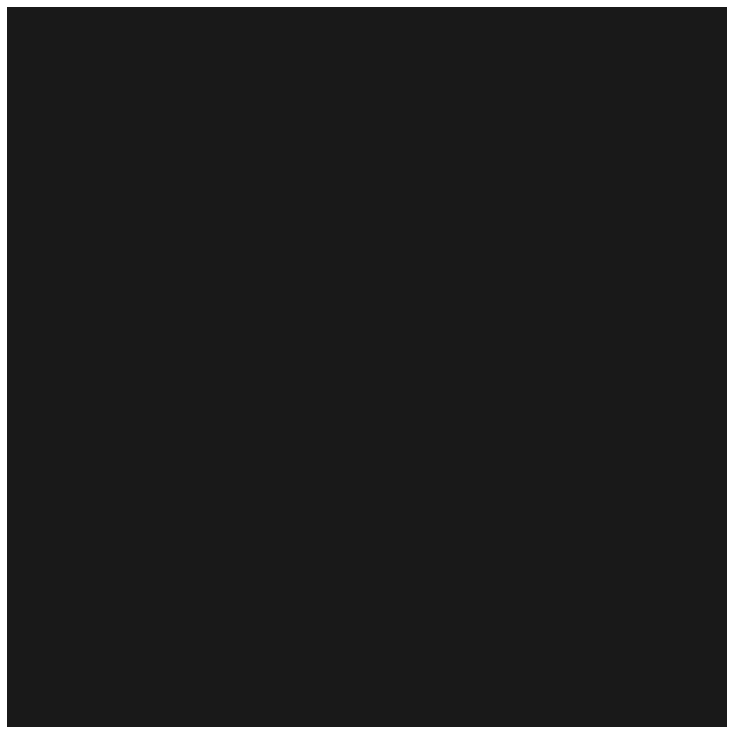

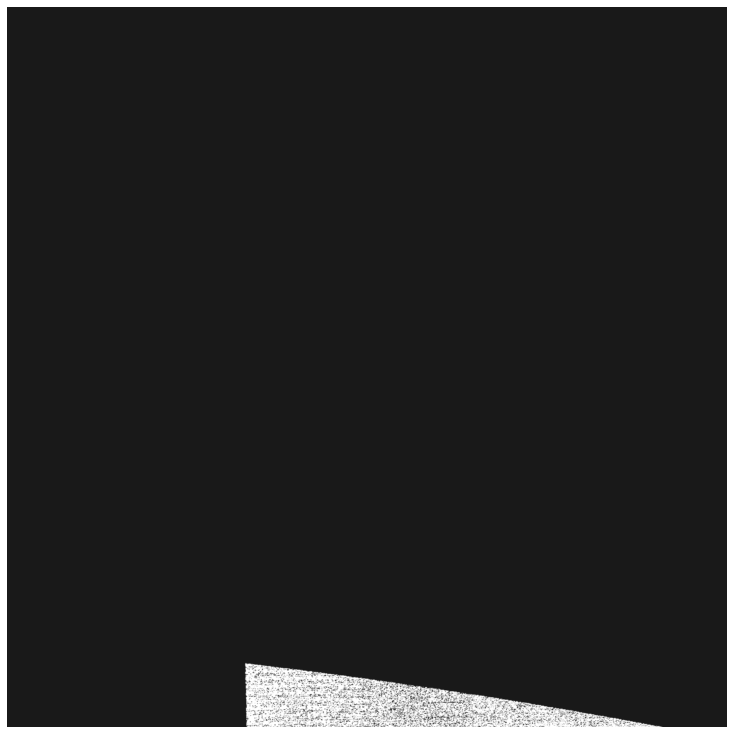

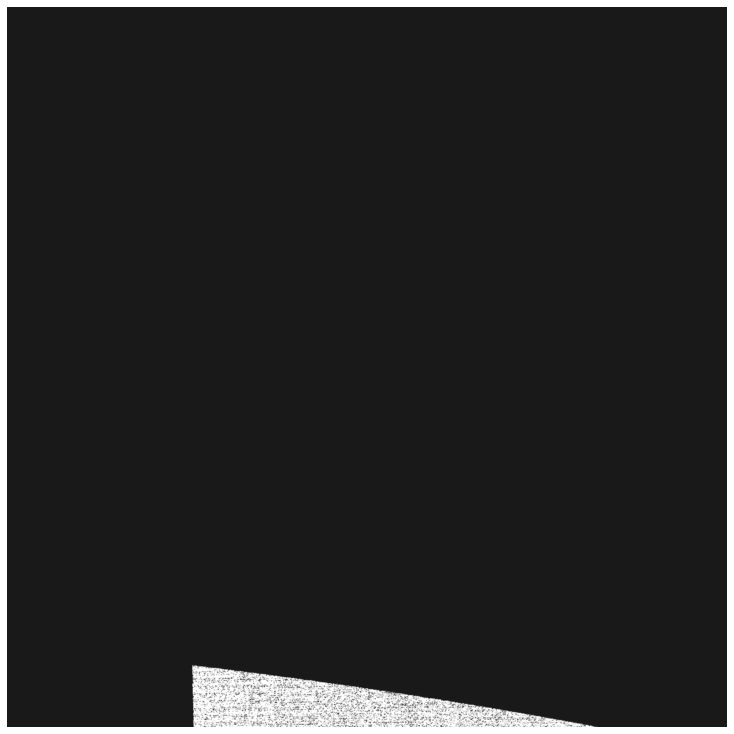

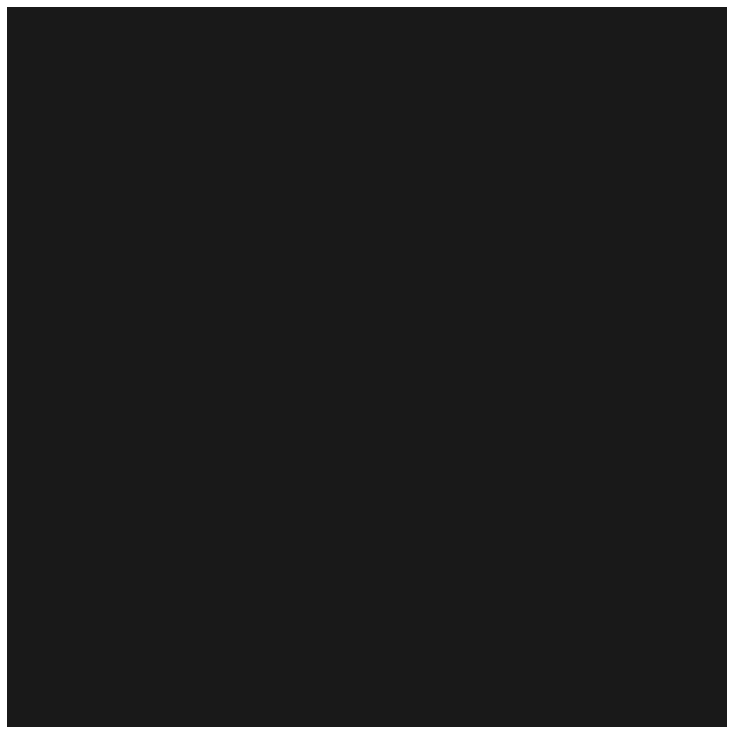

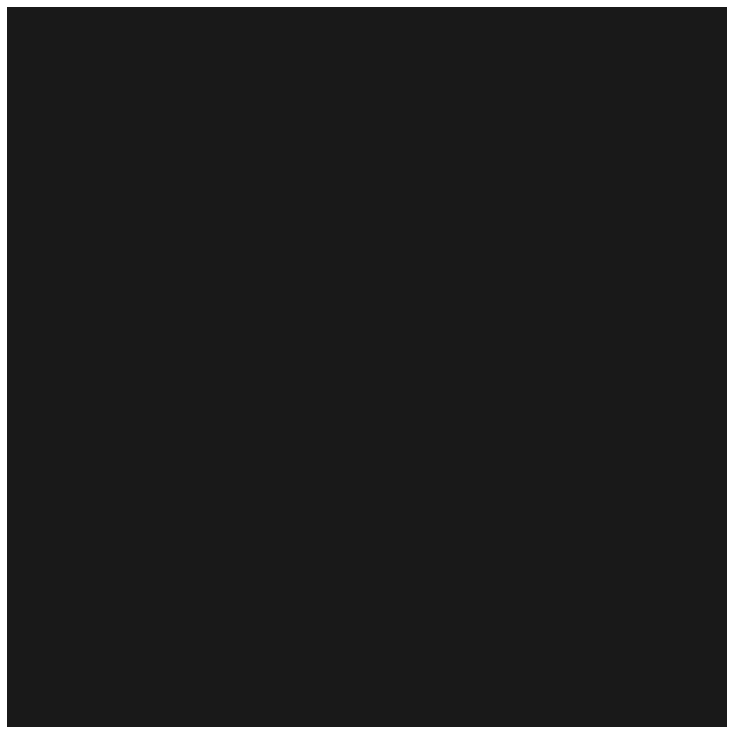

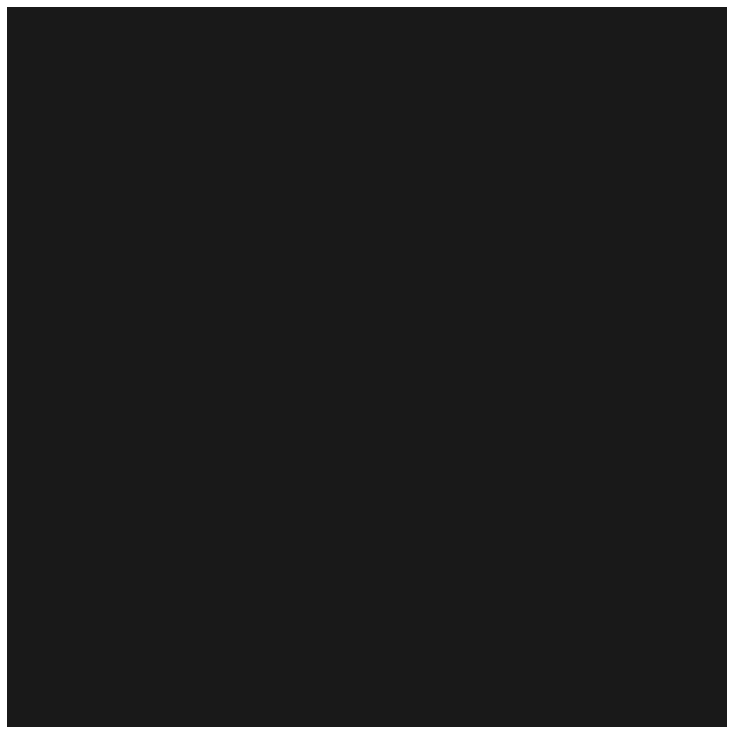

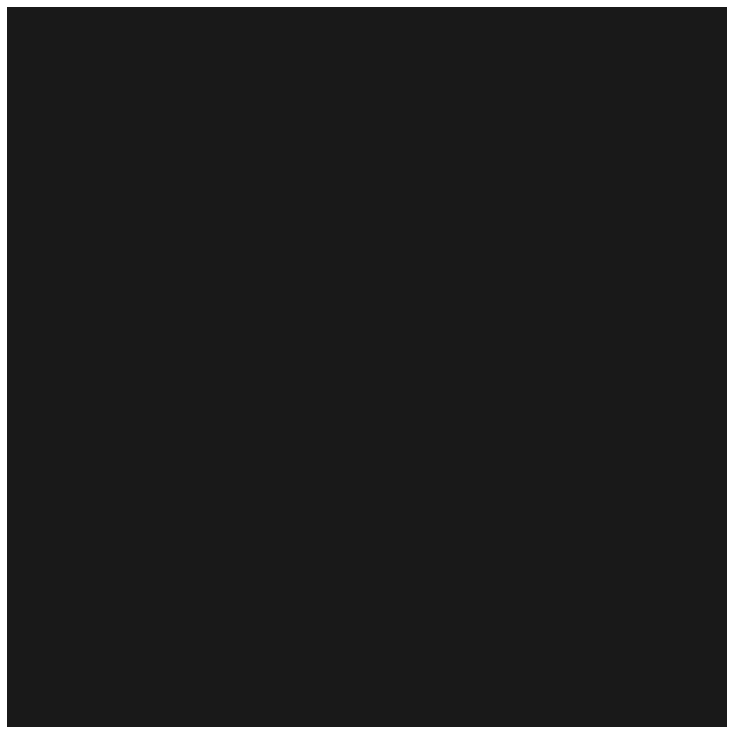

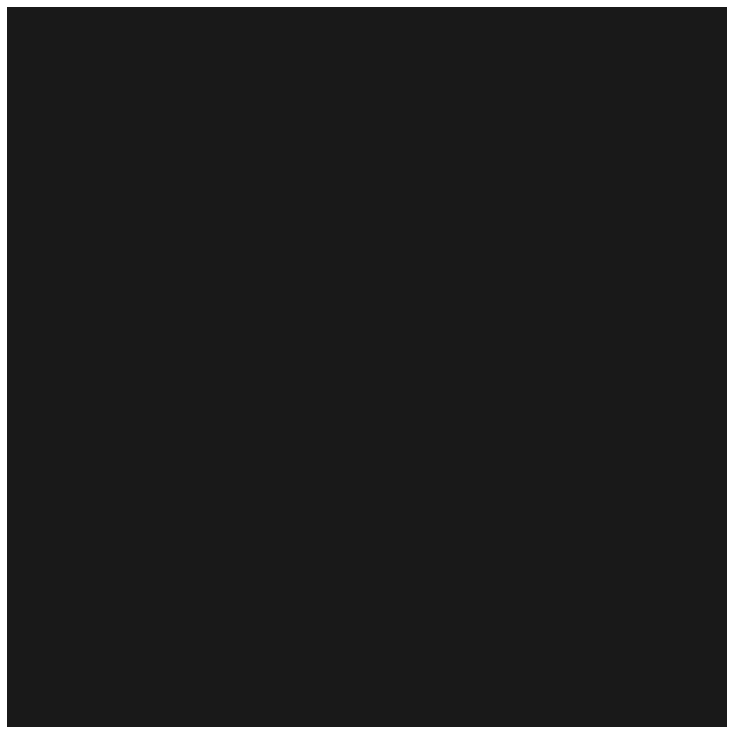

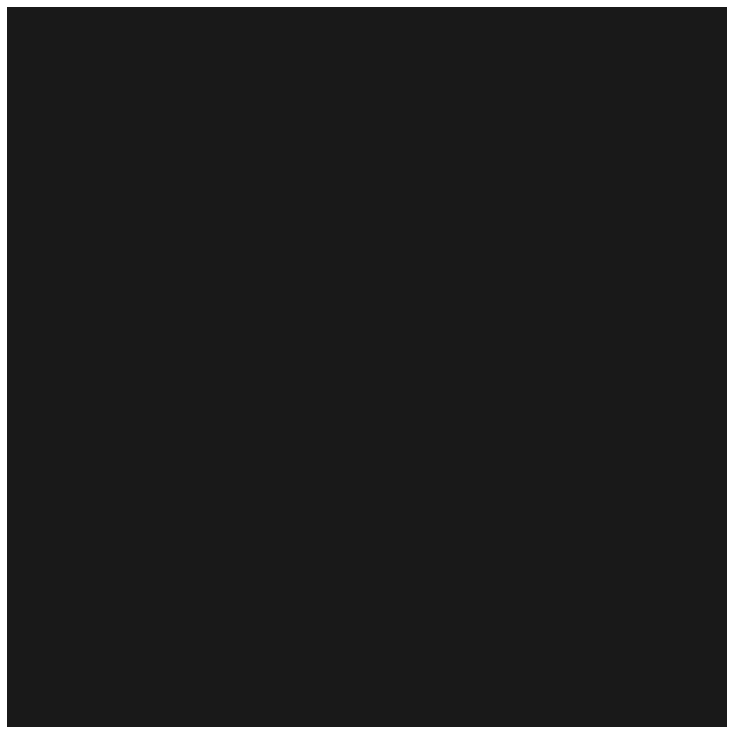

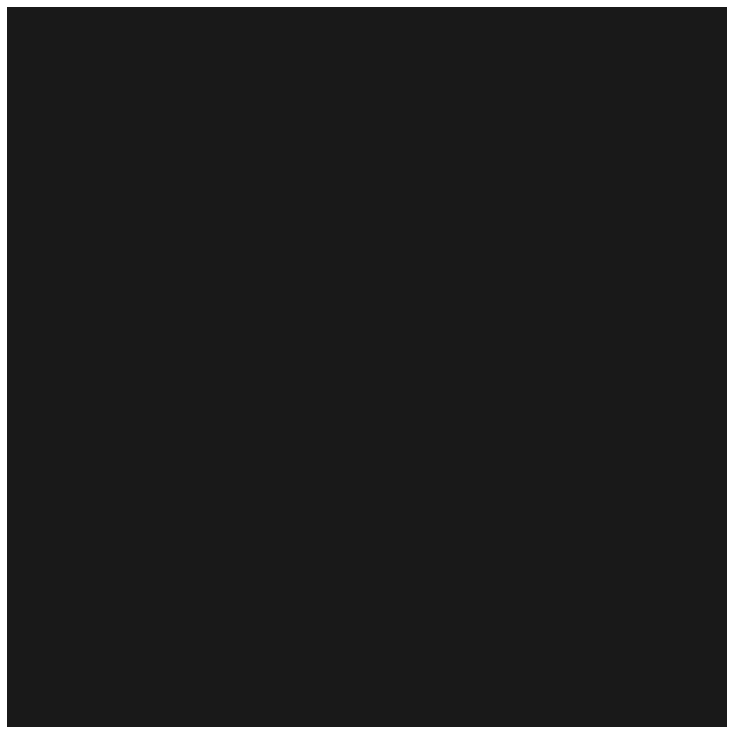

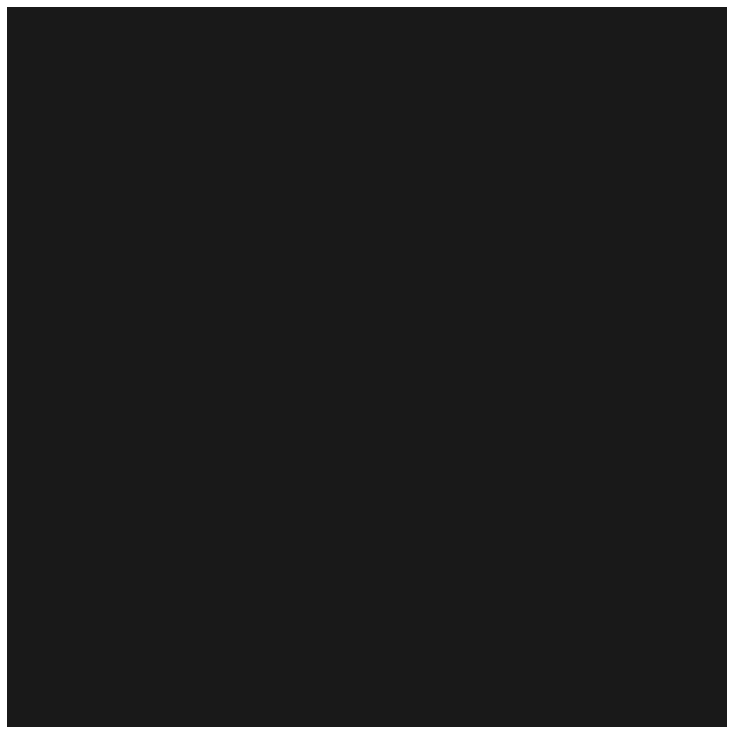

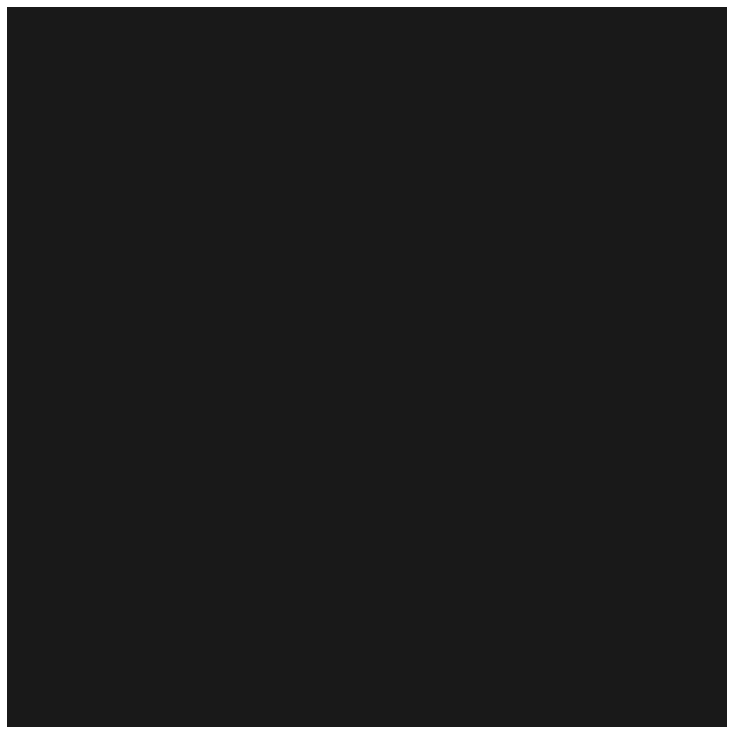

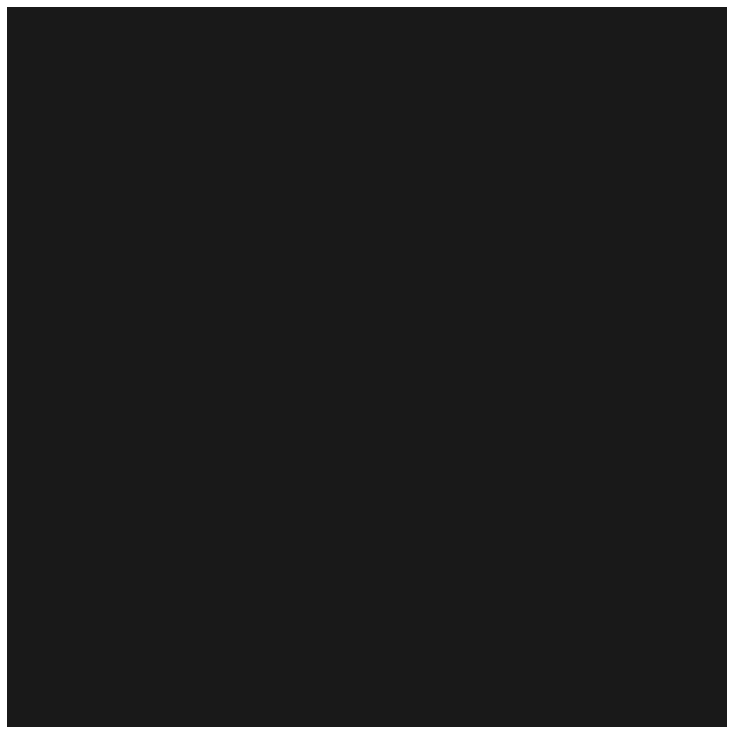

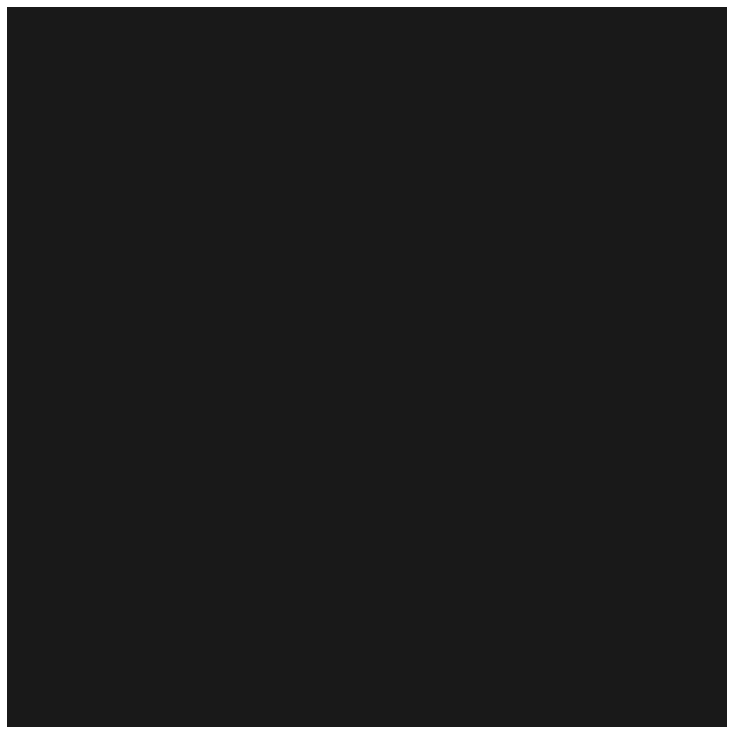

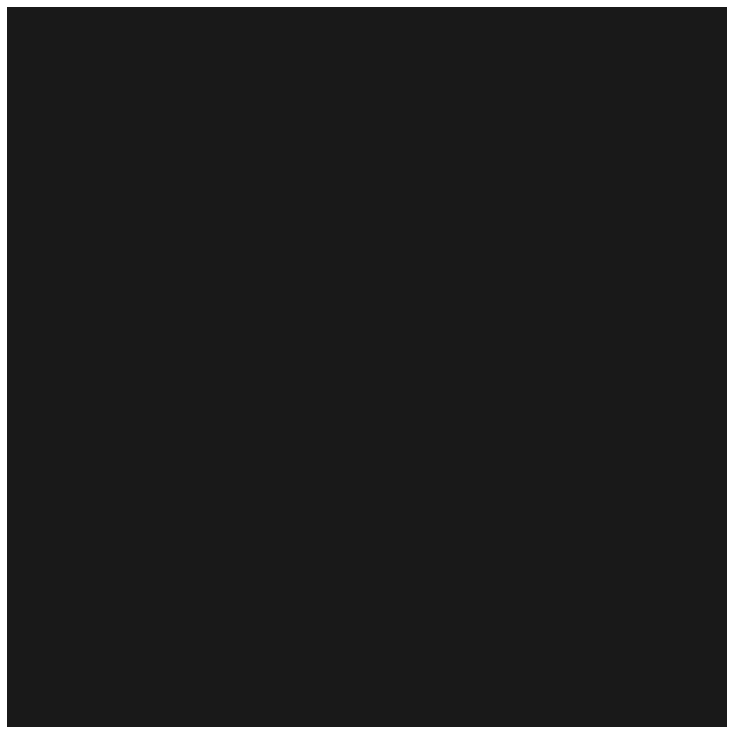

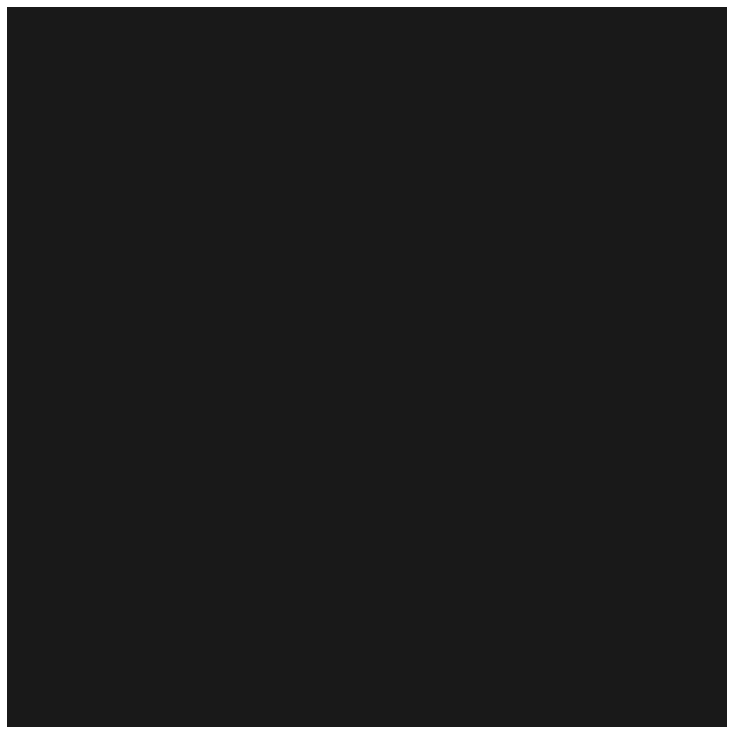

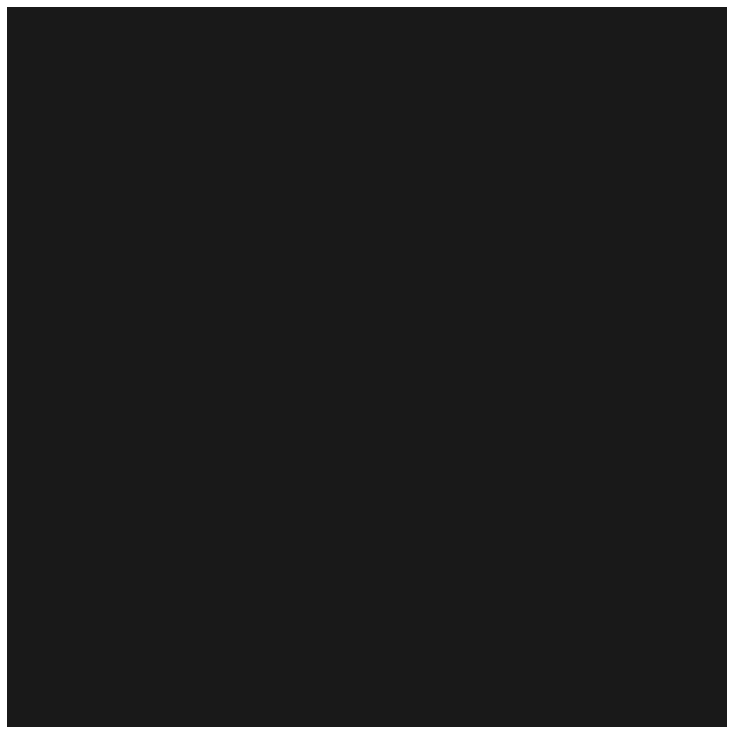

In [39]:
for inFile in os.listdir("./Data"):
    f = h5py.File("./Data/" + inFile,"r")
    outName = inFile.rsplit('.', 1)[0]                      # Parse out the file extension, keep file nameoutName
    noext = outName[-13:]
    dt = dt.strptime(noext, "%Y%j%H%M%S")
    fileMetadata = f['HDFEOS INFORMATION']['StructMetadata.0'].value.split() # Read file metadata
    fileMetadata = [m.decode('utf-8') for m in fileMetadata]                 # Clean up file metadata
    grids = list(f['HDFEOS']['GRIDS']) # List contents of GRIDS directory
    h5_objs = []            # Create empty list
    f.visit(h5_objs.append) # Walk through directory tree, retrieve objects and append to list
    # Search for SDS with 1km or 500m grid
    all_datasets = [obj for grid in grids for obj in h5_objs if isinstance(f[obj],h5py.Dataset) and grid in obj] 
    lum = f[[a for a in all_datasets if 'DNB_At' in a][0]]
    scaleFactor = lum.attrs['scale_factor'][0]
    fillValue = lum.attrs['_FillValue'][0]
    red = lum.value * scaleFactor
    green = lum.value * scaleFactor
    blue = lum.value * scaleFactor
    nir = lum.value * scaleFactor 
    rgb = np.dstack((red,green,blue)) # Create RGB array
    rgb[rgb == fillValue * scaleFactor] = 0      # Set fill value equal to 0
    p2, p98 = np.percentile(rgb, (2, 98))                              # Calculate 2nd,98th percentile for updating min/max vals
    rgbStretched = exposure.rescale_intensity(rgb, in_range=(p2, p98)) # Perform contrast stretch on RGB range
    rgbStretched = exposure.adjust_gamma(rgbStretched, 0.5)            # Perform Gamma Correction
    fig = plt.figure(figsize =(10,10))                           # Set the figure size
    ax = plt.Axes(fig,[0,0,1,1]) 
    ax.set_axis_off()                                            # Turn off axes
    fig.add_axes(ax)
    ax.imshow(rgbStretched, interpolation='bilinear', alpha=0.9) # Plot a natural color RGB

In [ ]:
f = h5py.File("VNP46A1.A2020149.h11v06.001.2020150062723.h5", "r")
list(f.keys())

In [ ]:
m10 = f['HDFEOS']["GRIDS"]["VNP_Grid_DNB"]["Data Fields"]["Radiance_M10"]
m11 = f['HDFEOS']["GRIDS"]["VNP_Grid_DNB"]["Data Fields"]["Radiance_M11"]
DNB = f['HDFEOS']["GRIDS"]["VNP_Grid_DNB"]["Data Fields"]["DNB_At_Sensor_Radiance_500m"]

In [ ]:
DNB.shape

In [ ]:
DNB.dtype

In [ ]:
m10[0,0]

In [ ]:
m11[0,0]

In [ ]:
f['HDFEOS INFORMATION'].keys()

In [ ]:
metadata = f['HDFEOS INFORMATION']['StructMetadata.0']

In [ ]:
metadata = metadata.value.split()

In [ ]:
fileMetadata = [m.decode('utf-8') for m in metadata]

In [ ]:
ulc = [i for i in fileMetadata if 'UpperLeftPointMtrs' in i][0]    # Search file metadata for the upper left corner of the file
ulcLon = float(ulc.split('=(')[-1].replace(')', '').split(',')[0]) # Parse metadata string for upper left corner lon value
ulcLat = float(ulc.split('=(')[-1].replace(')', '').split(',')[1]) # Parse metadata string for upper left corner lat value

In [ ]:
print(ulcLat,ulcLon)

In [ ]:
mat = np.reshape(DNB,(2400,2400))

In [ ]:
mat[mat => 255] = 0

In [ ]:
mat.max()

In [ ]:
np.where(mat == 131 )

In [ ]:
mat[mat == -1] = mat.max()

In [ ]:
mat_norm

In [ ]:
mat_norm = (mat - mat.min()) / (mat.max() - mat.min())

In [ ]:
img = Image.fromarray(np.uint8(mat) , 'L')

In [ ]:
img.save("nice.jpg","JPEG")

In [ ]:
array = np.linspace(0,1,256*256)

# reshape to 2d
mat = np.reshape(array,(256,256))

# Creates PIL image
img = Image.fromarray(np.uint8(mat * 255) , 'L')
img.save("nice.jpg","JPEG")